#### NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 7 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
import sys
#sys.path.append('./../')
#!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
#gdown.download(url, output, quiet=False, fuzzy=True)

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


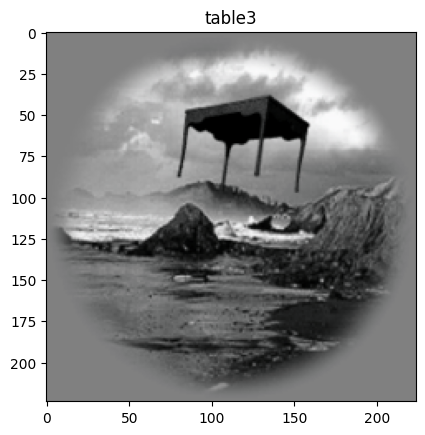

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

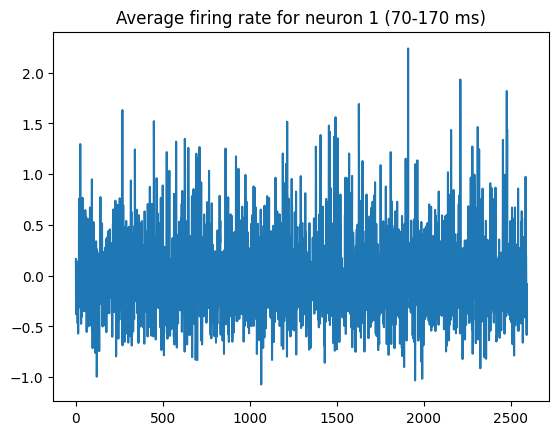

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Predict the neural activity using a data-driven approach

In the first part of the project, you have predicted the neural activity either from pixels or from the activations of a pre-trained neural network model. Here, your objective is to build and train a shallow convolutional neural network to predict the IT neural activity.

Follow these steps:
- Create the dataloader
- Define the model (Shallow CNN with 2/3 layers)
- Define the loss function (MSE) and the optimizer
- Build the training script and train your model
- Evaluate the predictions of your model. 
- Compare the neural predictions with the ones achieved by the task-trained neural network model. Which one can better predict the neural activity?

In [10]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
!nvidia-smi

Tue May  6 16:25:41 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:D8:00.0 Off |                  Off |
| N/A   32C    P0              26W / 250W |      4MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
### Here your code
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import r2_score, explained_variance_score

print(torch.cuda.is_available())  # True if GPU with CUDA is available
print(torch.cuda.device_count())
print(torch.cuda.current_device()) 
print(torch.cuda.get_device_name(0))

True
1
0
Tesla V100-PCIE-32GB


In [11]:
class CNN(nn.Module):
    def __init__(self, height, width, output_n):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, output_n)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))

        return self.fc2(x)

In [12]:
class NeuralDataset(Dataset):
    def __init__(self, stimuli, spikes):
        self.stimuli = torch.tensor(stimuli, dtype=torch.float32)
        self.spikes = torch.tensor(spikes, dtype=torch.float32)

    def __len__(self):
        return len(self.stimuli)
    
    def __getitem__(self, idx):
        return self.stimuli[idx], self.spikes[idx]
    
def get_dataloaders(batch_size, stimulus_train, spikes_train, stimulus_val, spikes_val):
    train_set = NeuralDataset(stimulus_train, spikes_train)
    val_set = NeuralDataset(stimulus_val, spikes_val)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for stimuli, spikes in train_loader:
            stimuli = stimuli.to(device)
            spikes = spikes.to(device)
            optimizer.zero_grad()
            outputs = model(stimuli)
            loss = criterion(outputs, spikes)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Training Loss: {total_loss / len(train_loader):.4f}")

In [20]:
from scipy.stats import gaussian_kde

def inspect_ridge(predictions_train_ridge, predictions_val_ridge, spikes_val, name):
    # Correlate the neurons of the model with each other and plot the correlation matrix
    correlation_matrix = np.corrcoef(predictions_train_ridge.T)

    # Create the 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # --- Subplot 1: Correlation matrix ---
    im = axes[0].imshow(correlation_matrix, cmap='hot', interpolation='nearest')
    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label('Correlation Coefficient')
    axes[0].set_title('Correlation matrix of predicted neurons')
    axes[0].set_xlabel('Neuron index')
    axes[0].set_ylabel('Neuron index')

    # --- Subplot 2: Explained variance scatter ---
    ev_scores = [explained_variance_score(spikes_val[:, i], predictions_val_ridge[:, i]) for i in range(n_neurons)]
    axes[1].scatter(range(n_neurons), ev_scores)
    axes[1].set_xlabel('Neuron index')
    axes[1].set_ylabel('Explained variance')
    axes[1].set_title('Explained variance for each neuron')

    # --- Subplot 3: Histogram + density of explained variance ---
    axes[2].hist(ev_scores, bins=20, density=True, alpha=0.5, color='b')
    density = gaussian_kde(ev_scores)
    x = np.linspace(min(ev_scores), max(ev_scores), 200)
    most_extreme = np.max(np.array([np.abs(np.min(ev_scores)), np.max(ev_scores)]))
    axes[2].plot(x, density(x), 'r', linewidth=2)
    max_density_val = x[np.argmax(density(x))]
    axes[2].axvline(x=max_density_val, color='g', linestyle='--', label=f'Max Density EV: {max_density_val:.2f}')
    axes[2].axvline(x=0, color='black', label="Naive Guess", alpha=0.5)
    axes[2].set_xlabel('Explained variance')
    axes[2].set_ylabel('Density')
    axes[2].set_title('Histogram and Density of explained variance')
    axes[2].set_xlim(-most_extreme, most_extreme)
    axes[2].legend()

    plt.tight_layout()
    plt.savefig(f'ridge_regression_analysis_{name}.png')
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = CNN(height=img_size, width=img_size, output_n=n_neurons)

model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loader, val_loader = get_dataloaders(16, stimulus_train, spikes_train, stimulus_val, spikes_val)

train_model(model, train_loader, criterion, optimizer, device, num_epochs=200)

torch.save(model.state_dict(), 'cnn_w7.pt')

cuda
Epoch 1, Training Loss: 0.1345
Epoch 2, Training Loss: 0.1327
Epoch 3, Training Loss: 0.1320
Epoch 4, Training Loss: 0.1310
Epoch 5, Training Loss: 0.1304
Epoch 6, Training Loss: 0.1298
Epoch 7, Training Loss: 0.1293
Epoch 8, Training Loss: 0.1286
Epoch 9, Training Loss: 0.1279
Epoch 10, Training Loss: 0.1266
Epoch 11, Training Loss: 0.1254
Epoch 12, Training Loss: 0.1246
Epoch 13, Training Loss: 0.1233
Epoch 14, Training Loss: 0.1225
Epoch 15, Training Loss: 0.1221
Epoch 16, Training Loss: 0.1215
Epoch 17, Training Loss: 0.1206
Epoch 18, Training Loss: 0.1205
Epoch 19, Training Loss: 0.1198
Epoch 20, Training Loss: 0.1192
Epoch 21, Training Loss: 0.1186
Epoch 22, Training Loss: 0.1181
Epoch 23, Training Loss: 0.1177
Epoch 24, Training Loss: 0.1173
Epoch 25, Training Loss: 0.1166
Epoch 26, Training Loss: 0.1162
Epoch 27, Training Loss: 0.1159
Epoch 28, Training Loss: 0.1153
Epoch 29, Training Loss: 0.1151
Epoch 30, Training Loss: 0.1149
Epoch 31, Training Loss: 0.1143
Epoch 32, Tr

In [37]:
def evaluate_model(model, train_loader, test_loader, device):
    model.eval()
    total_mse = 0
    predictions_list = []
    targets_list = []

    train_iter = iter(train_loader)
    with torch.no_grad():
        for stimuli, spikes in test_loader:
            stimuli = stimuli.to(device)
            spikes = spikes.to(device)
            outputs = model(stimuli)
            total_mse += nn.MSELoss()(outputs, spikes).item()
            predictions_list.append(outputs.cpu())
            targets_list.append(spikes.cpu())
            
            try:
                train_stim, train_spikes = next(train_iter)
            except StopIteration:
                train_iter = iter(train_loader)
                train_stim, train_spikes = next(train_iter)

            train_spikes = train_spikes.to(device)
            train_outputs = model(train_stim.to(device))

            outputs = np.array(outputs.cpu())
            train_outputs = np.array(train_outputs.cpu())
            spikes = np.array(spikes.cpu())

            print(train_outputs.shape, outputs.shape, spikes.shape)
    
            inspect_ridge(train_outputs, outputs, spikes, len(predictions_list))

    
    predictions = np.concatenate(predictions_list, axis=0)
    targets = np.concatenate(targets_list, axis=0)

    r2 = r2_score(targets, predictions)
    explained_variance = explained_variance_score(targets, predictions)


    print(f"R2 Score: {r2}")
    print(f"Explained Variance: {explained_variance}")

    print(f"Test MSE: {total_mse / len(test_loader):.4f}")
    return torch.cat(predictions_list), torch.cat(targets_list)

cuda
<class 'torch.utils.data.dataloader.DataLoader'>
(16, 168) (16, 168) (16, 168)


/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


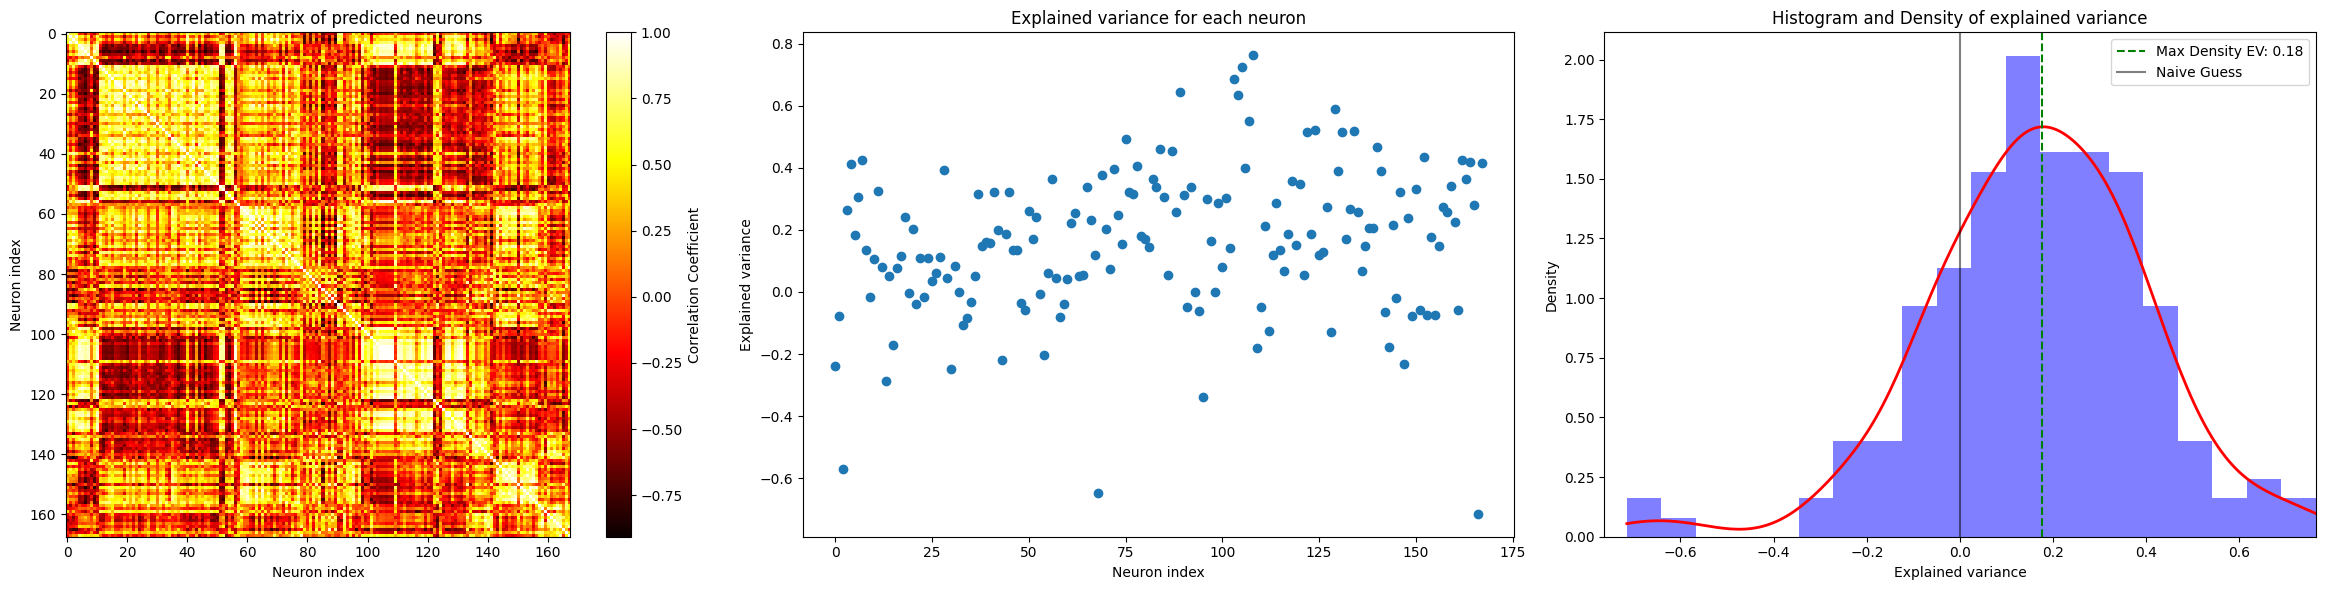

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


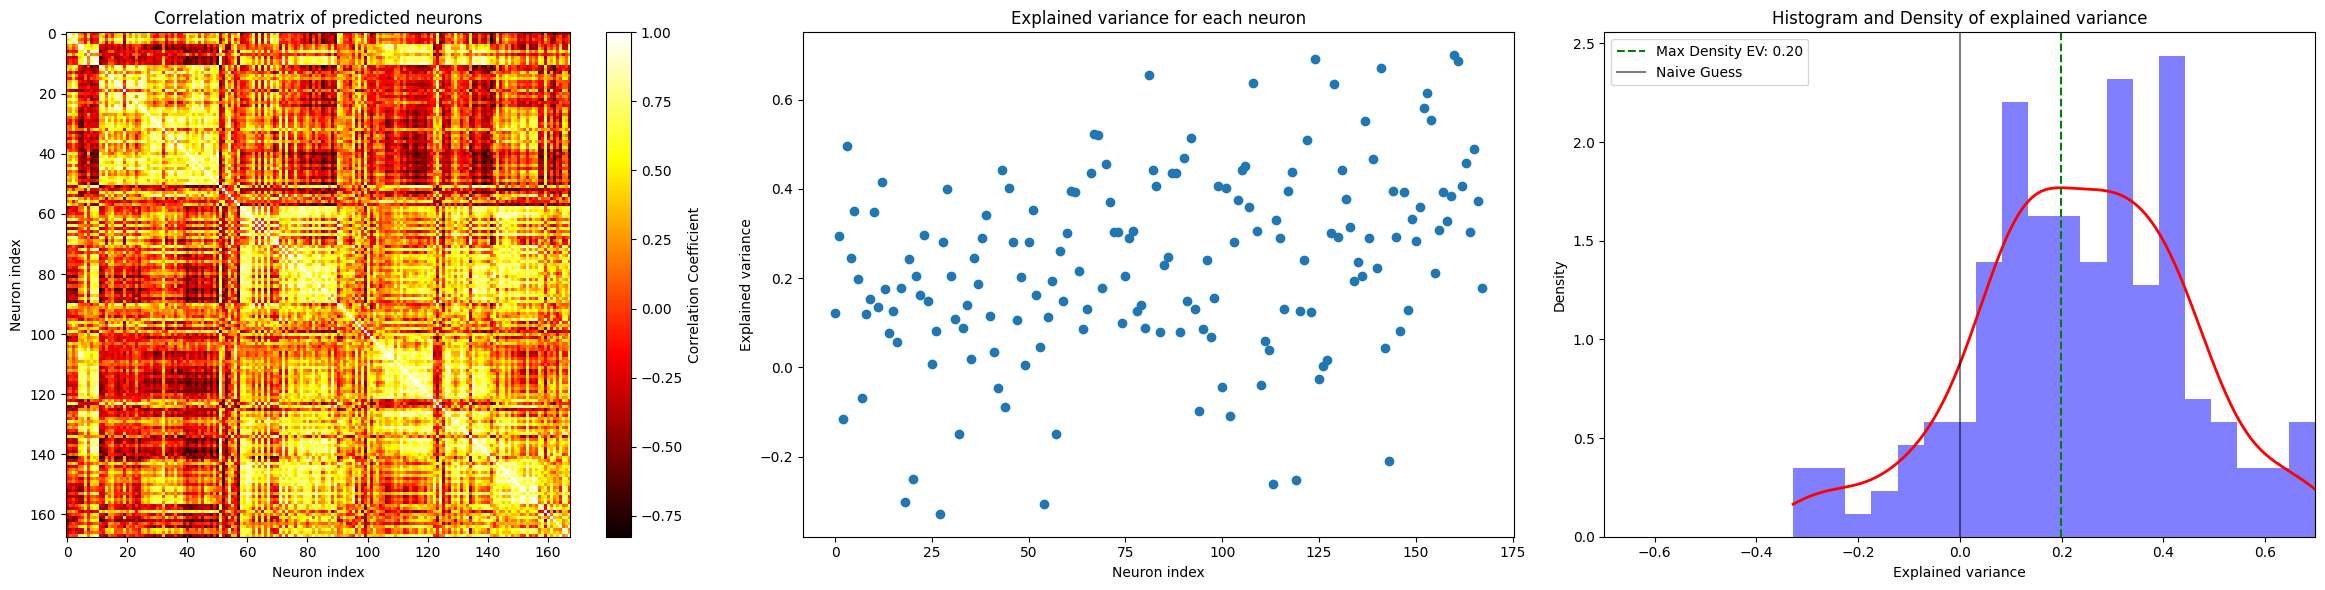

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


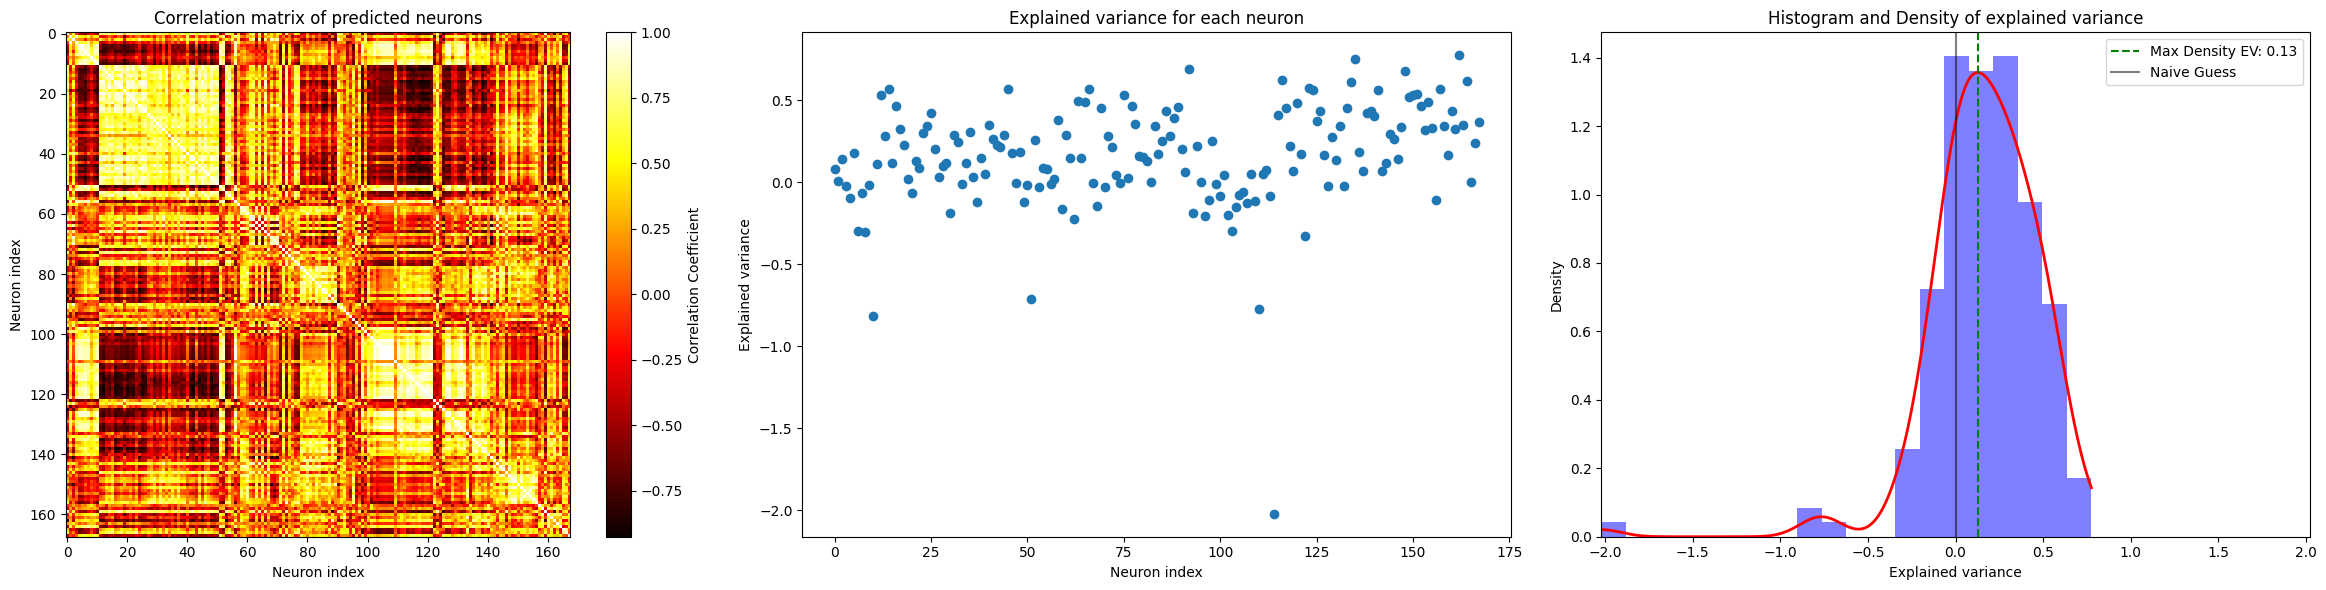

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


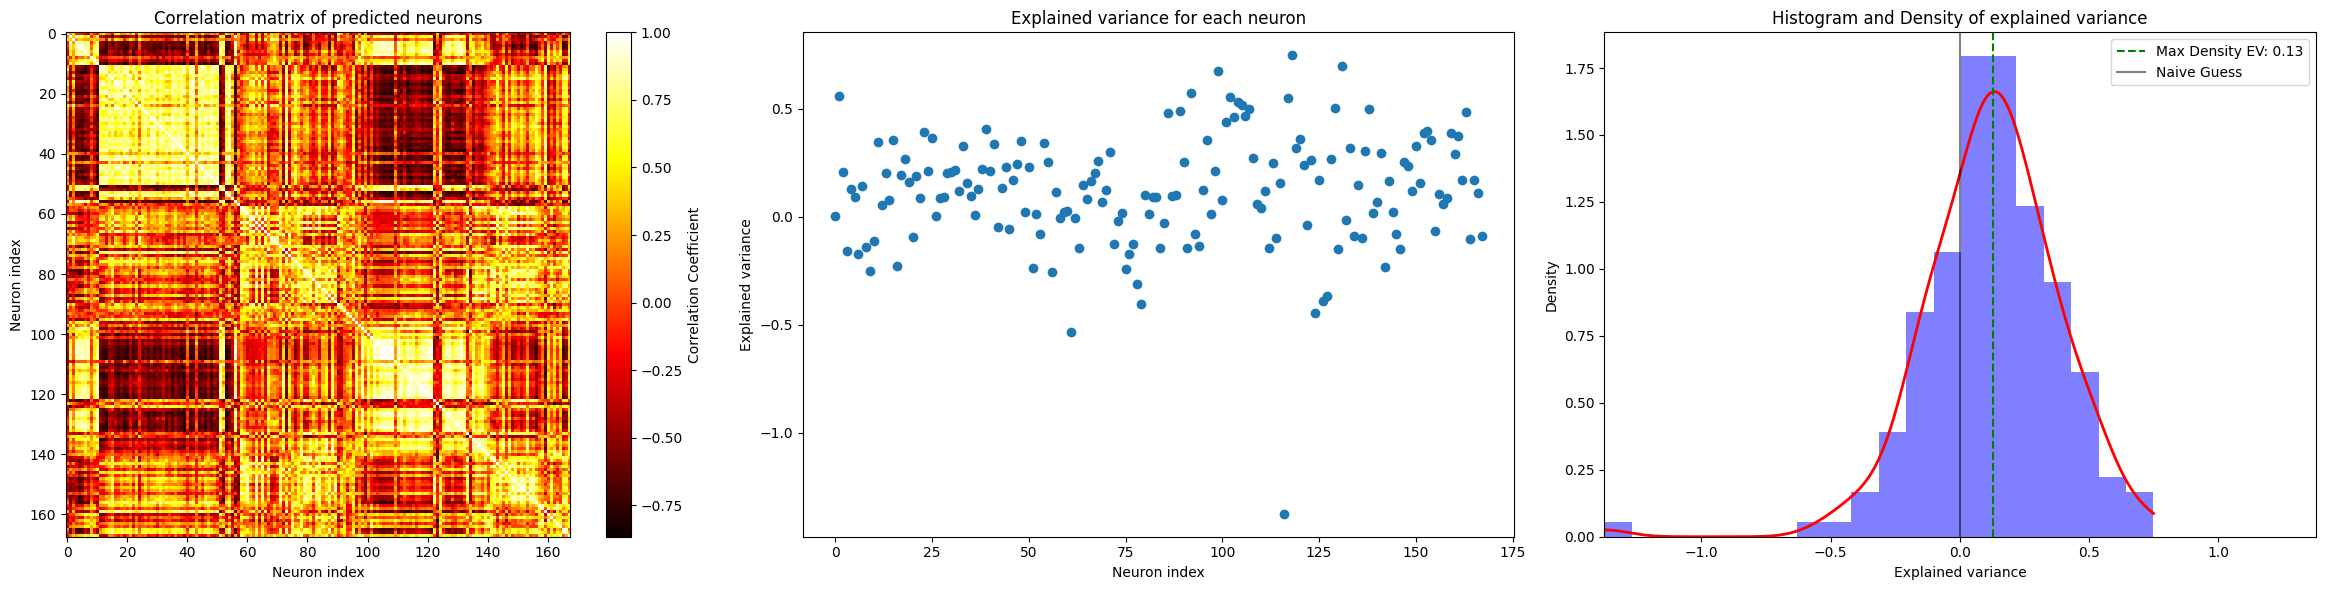

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


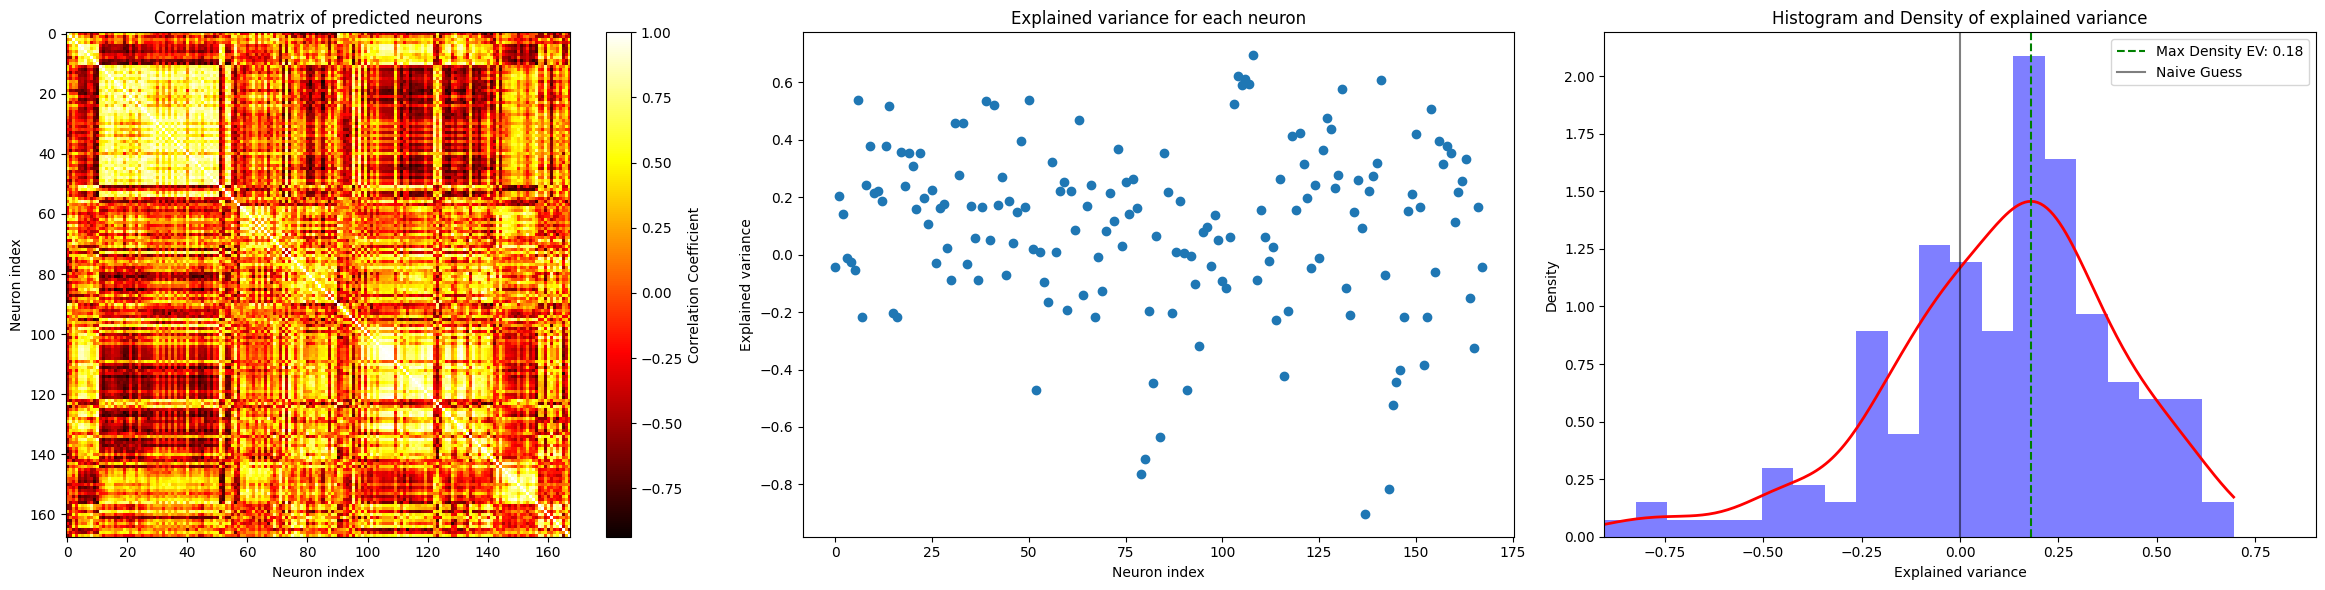

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


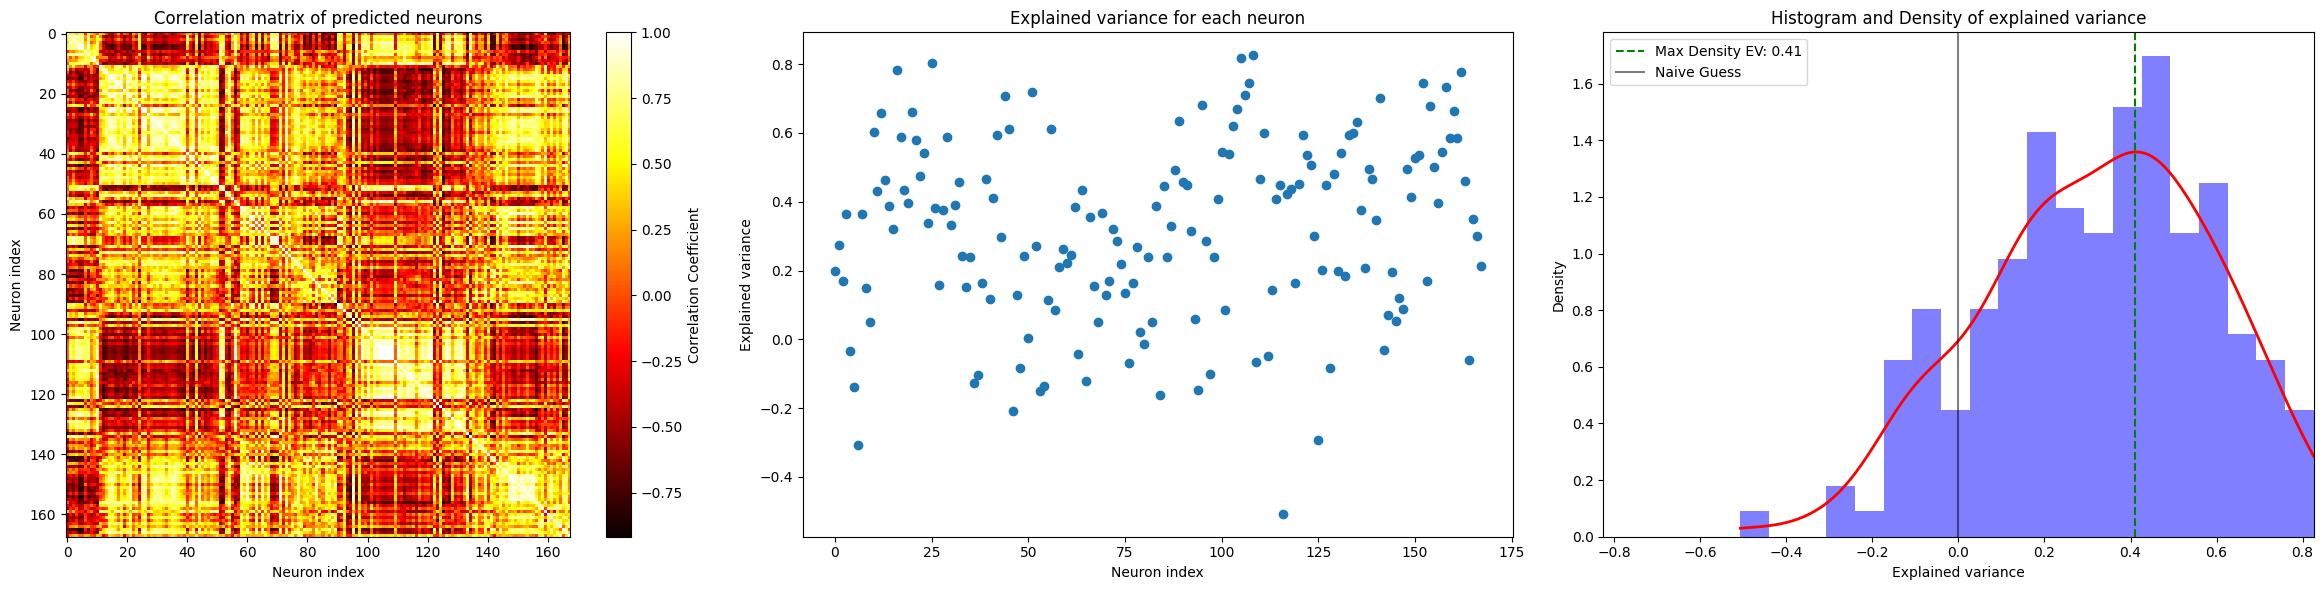

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


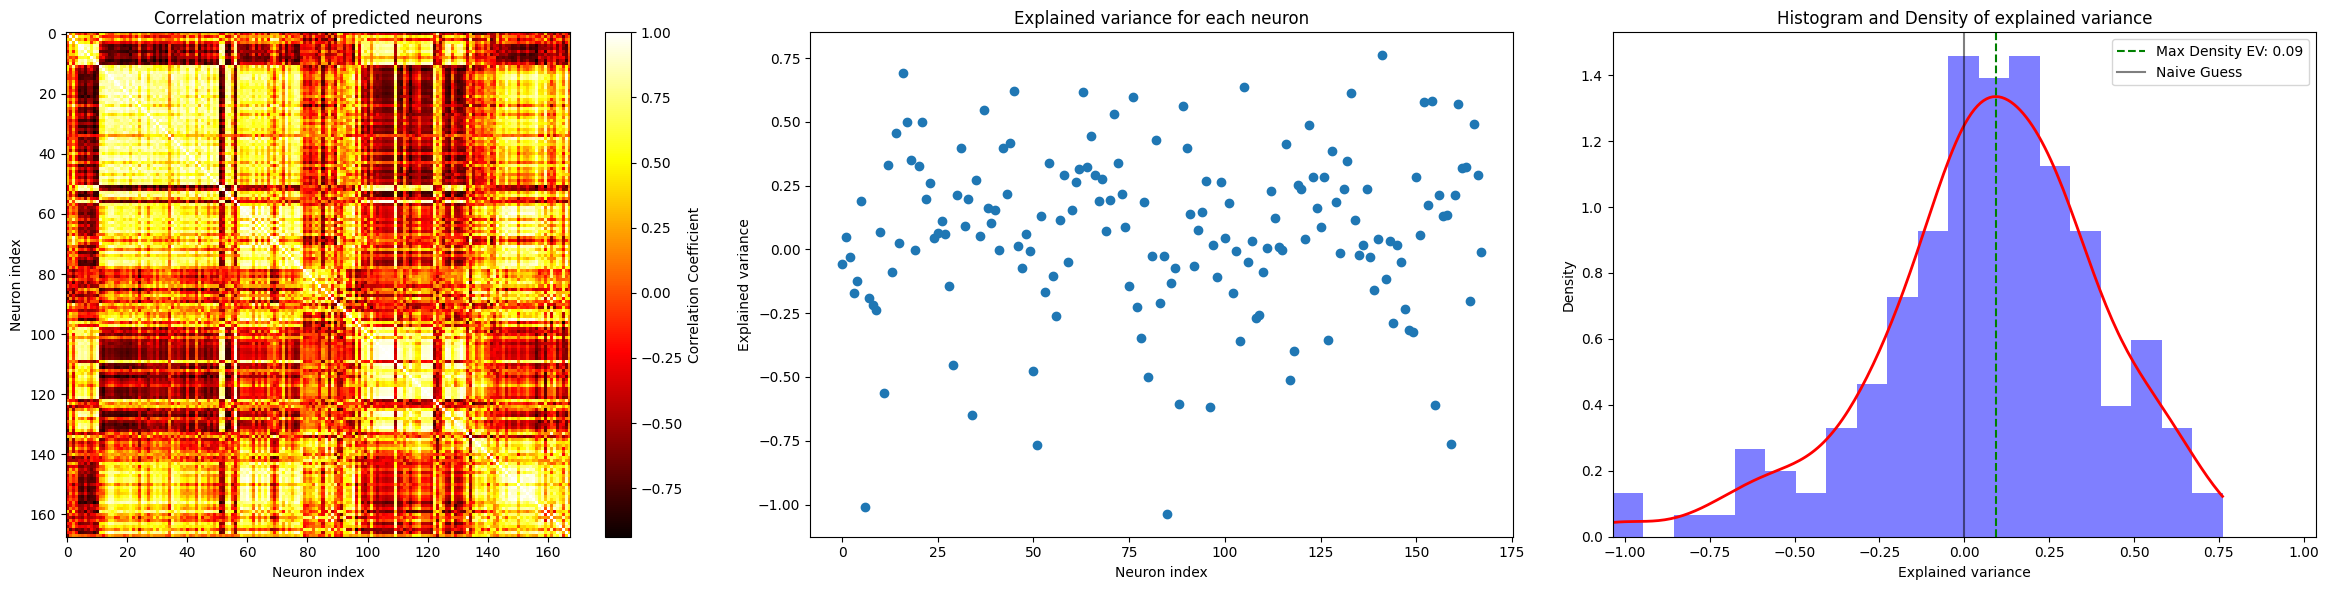

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


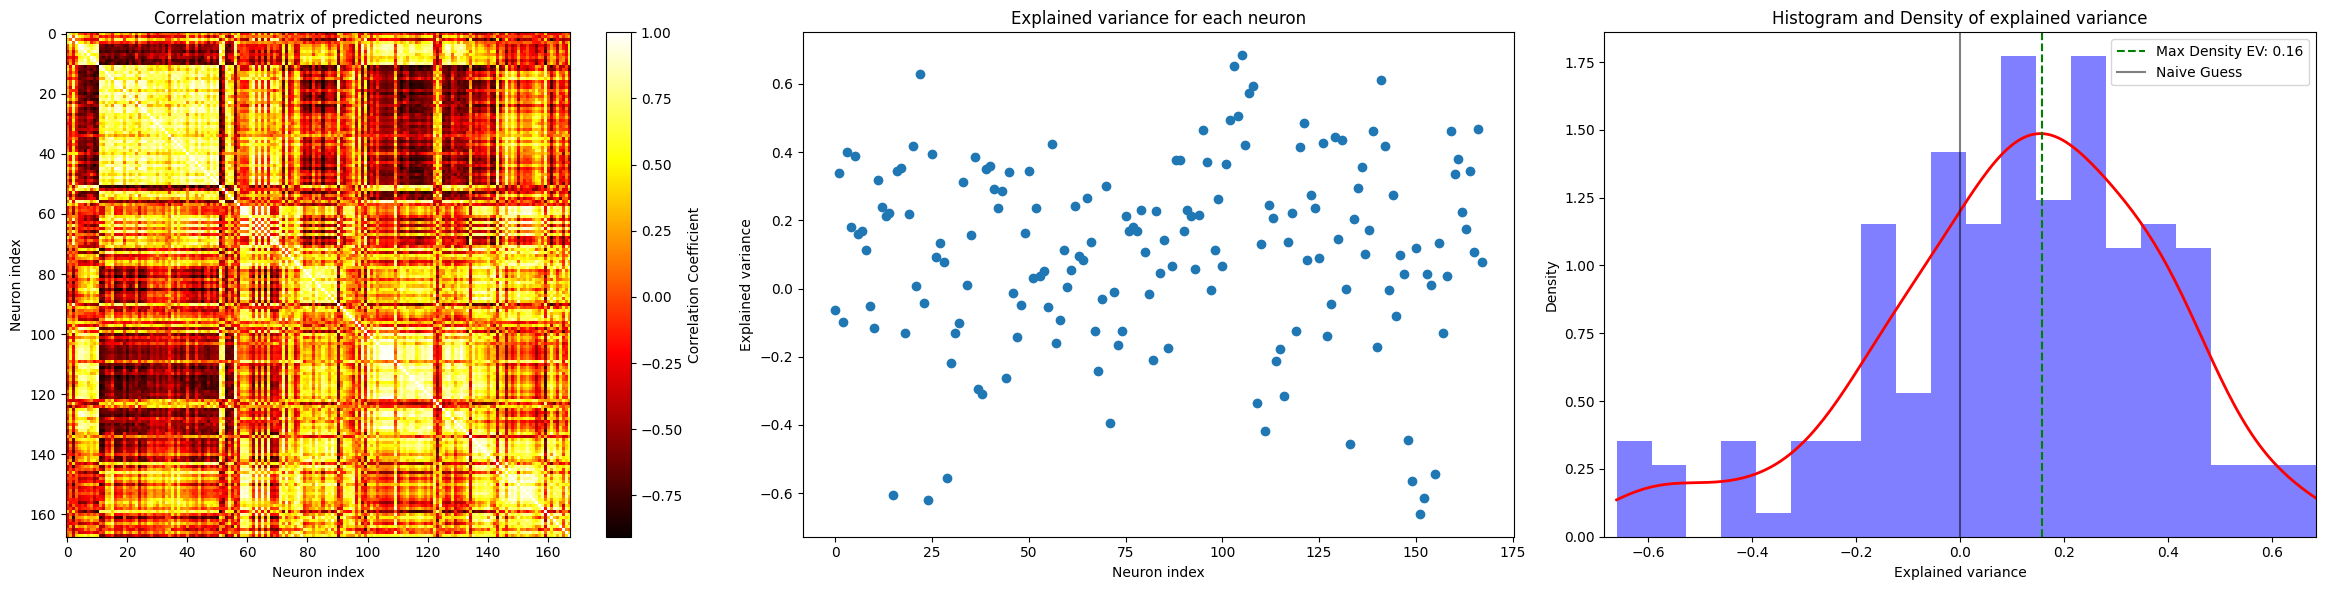

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


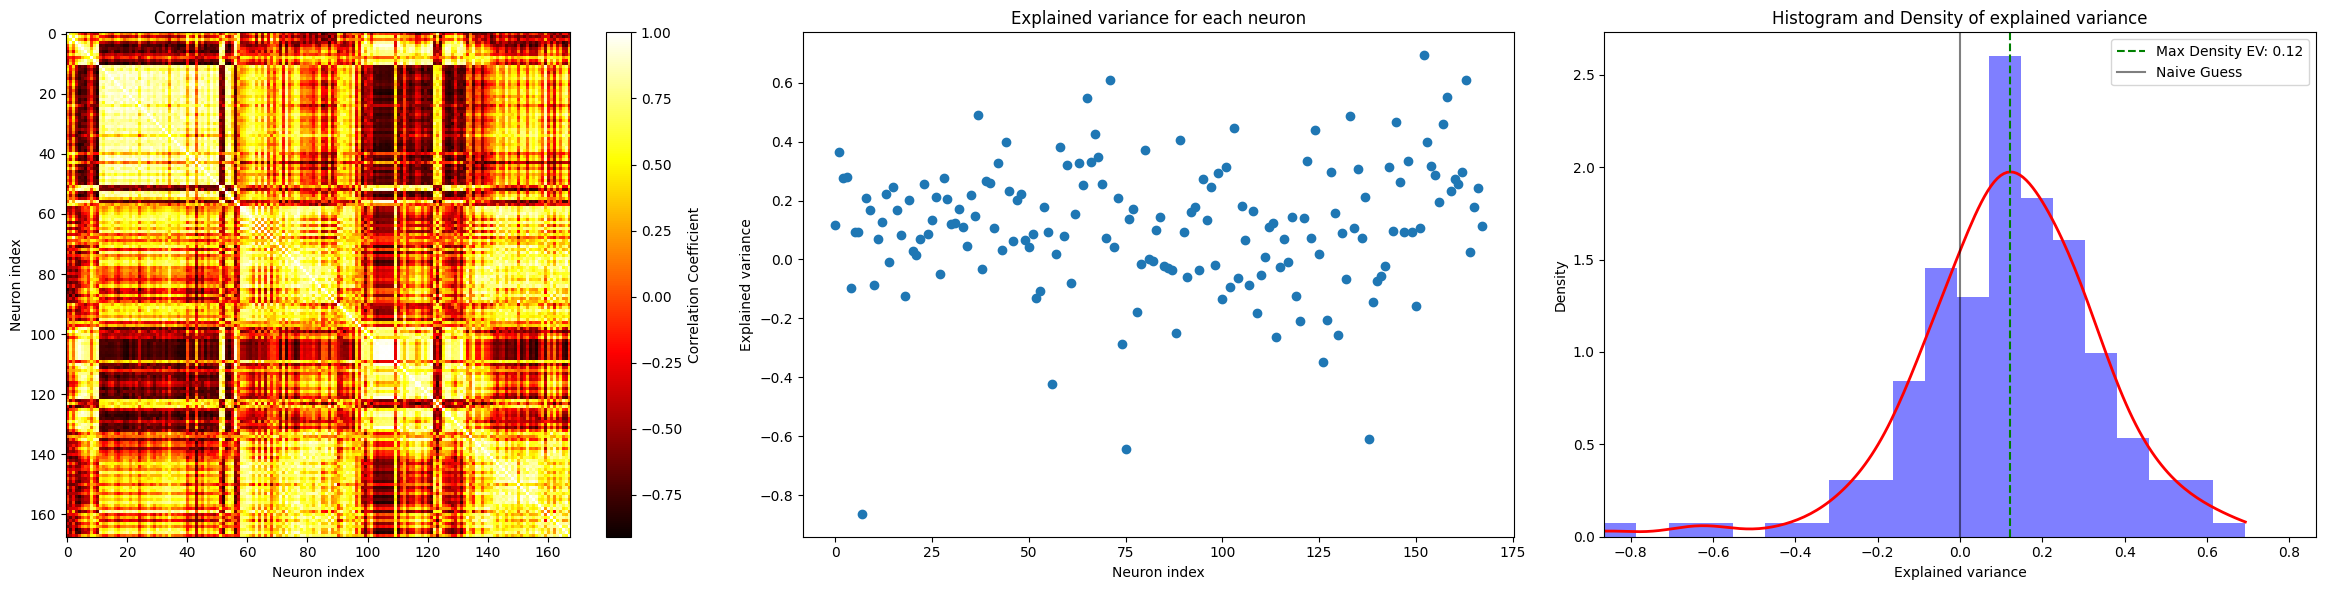

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


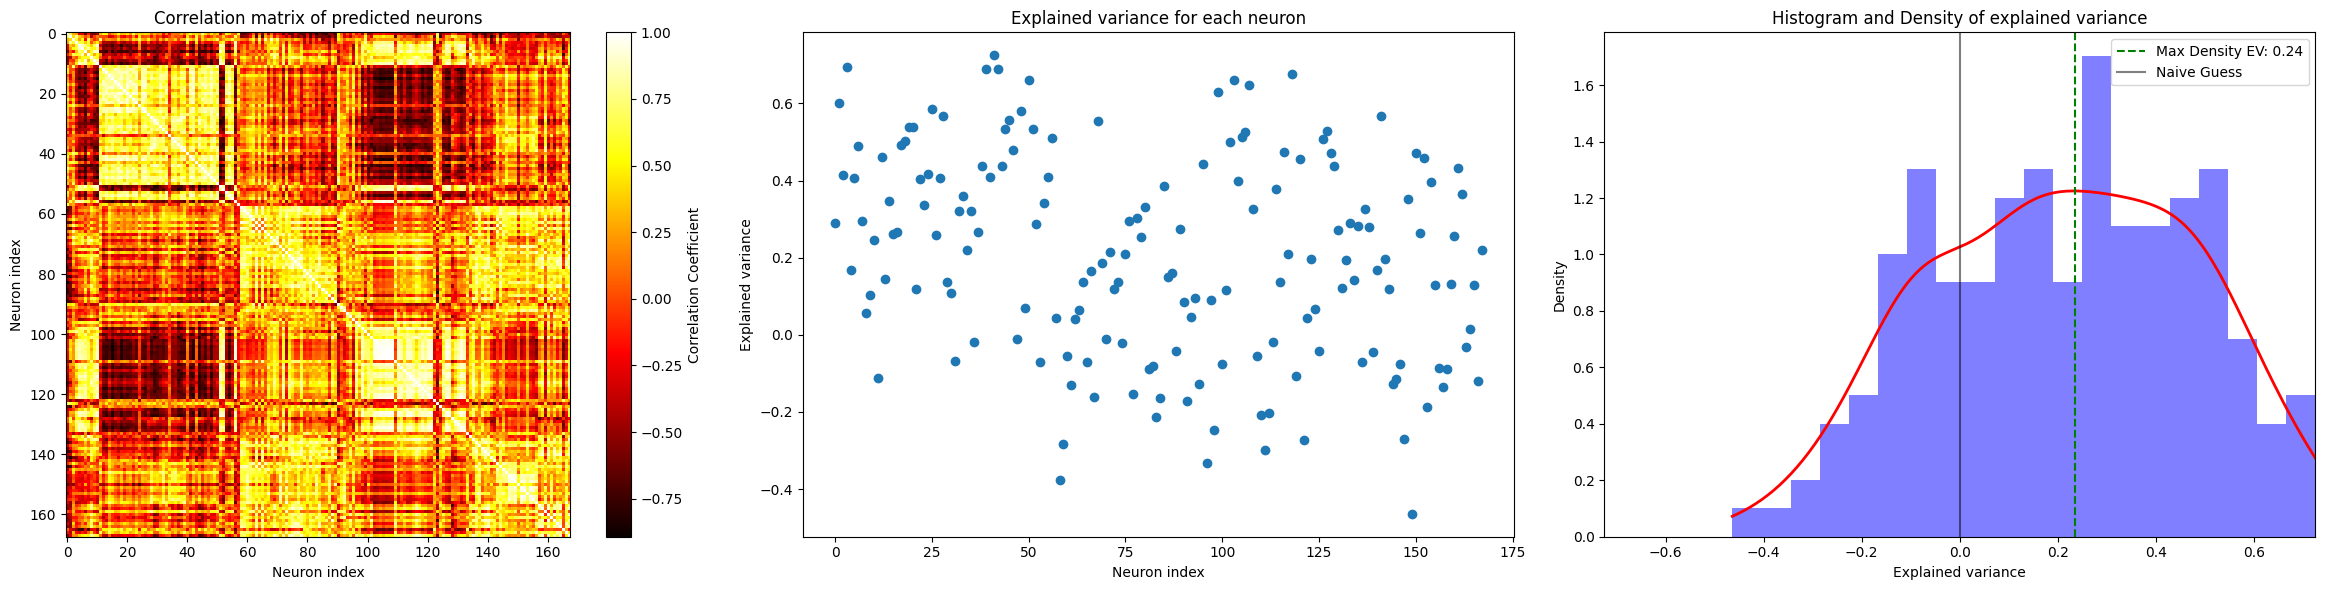

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


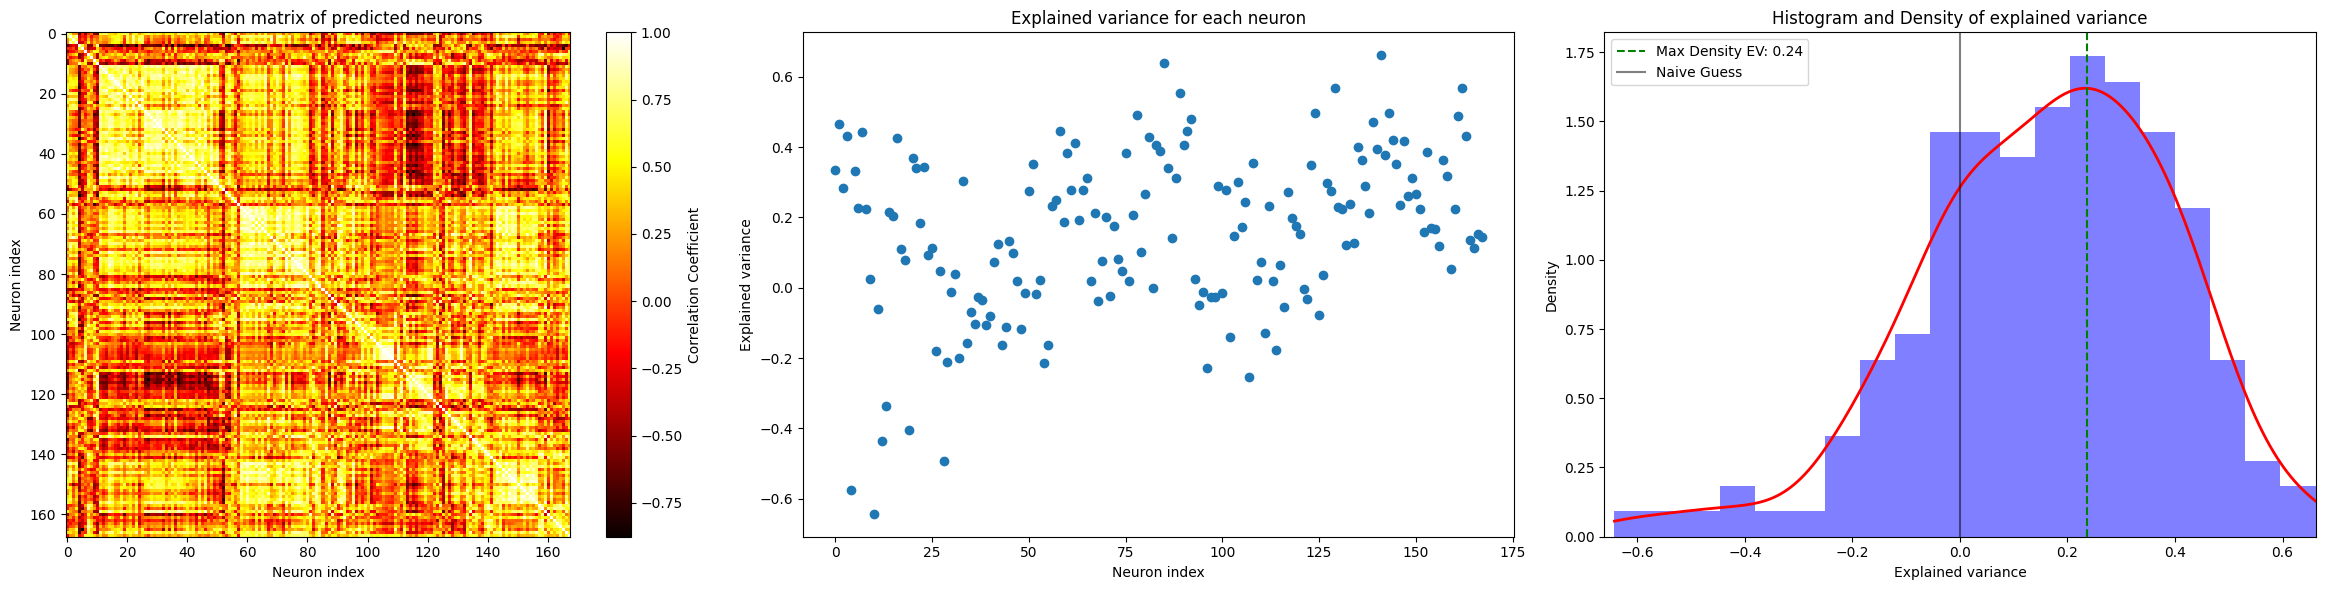

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


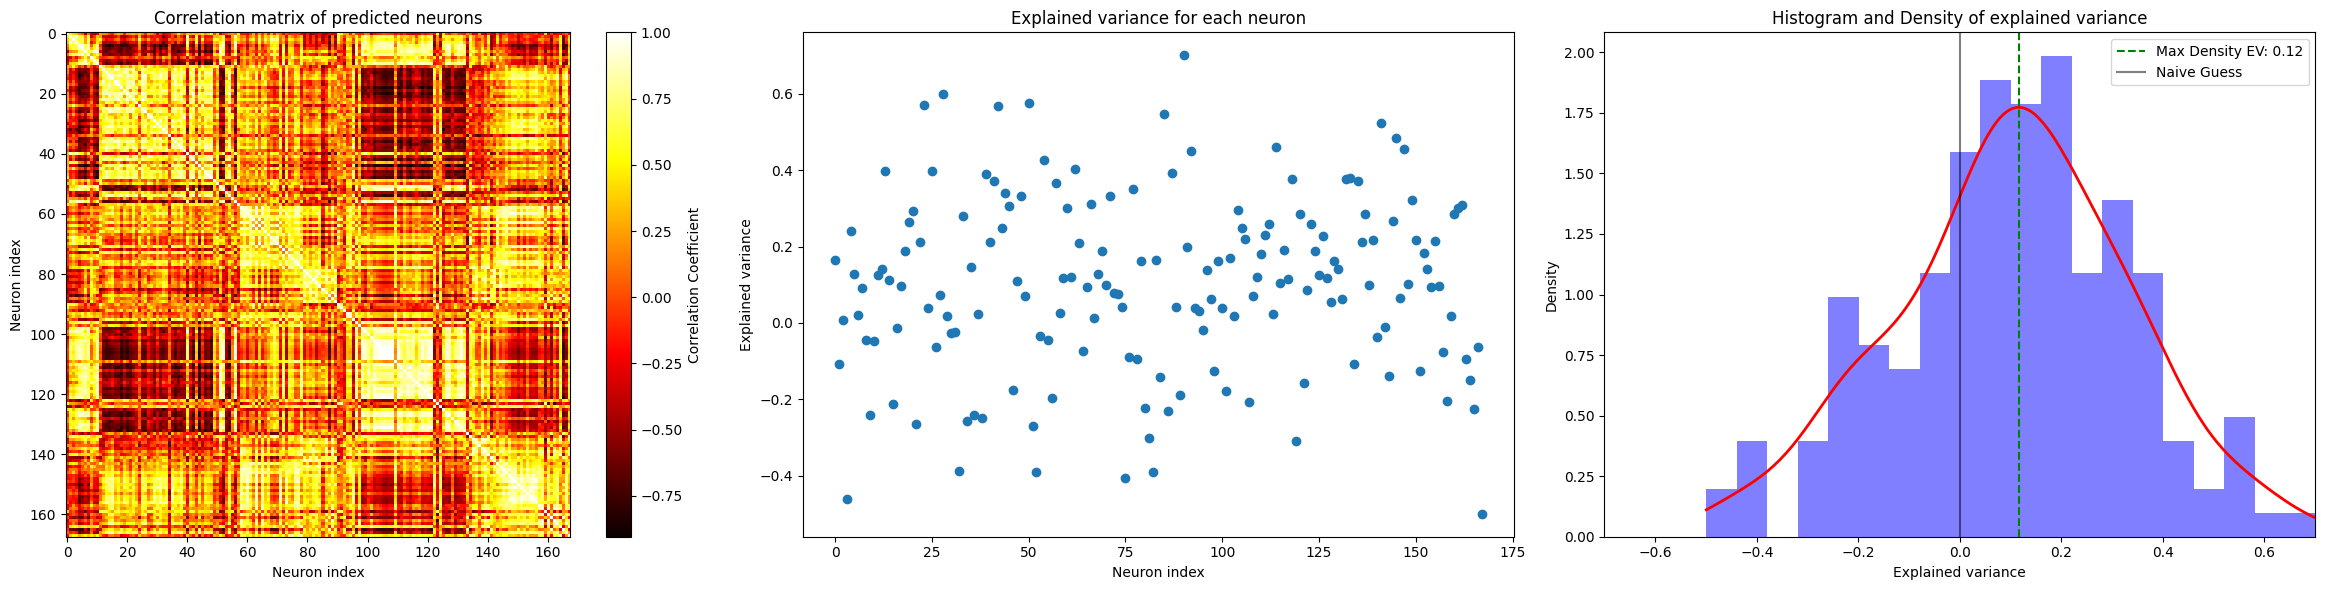

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


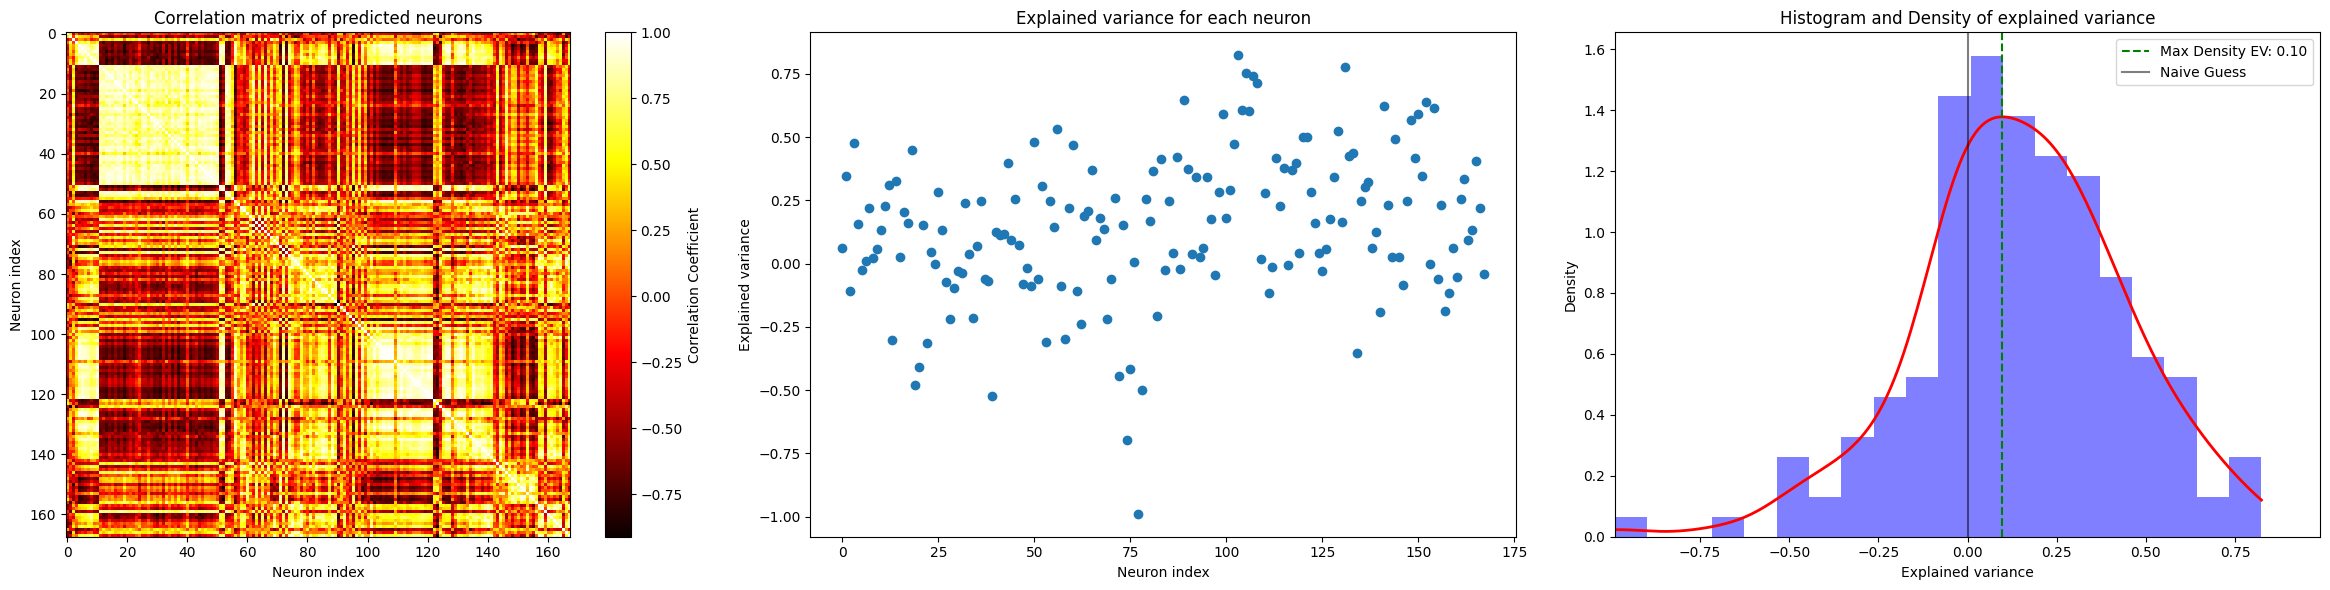

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


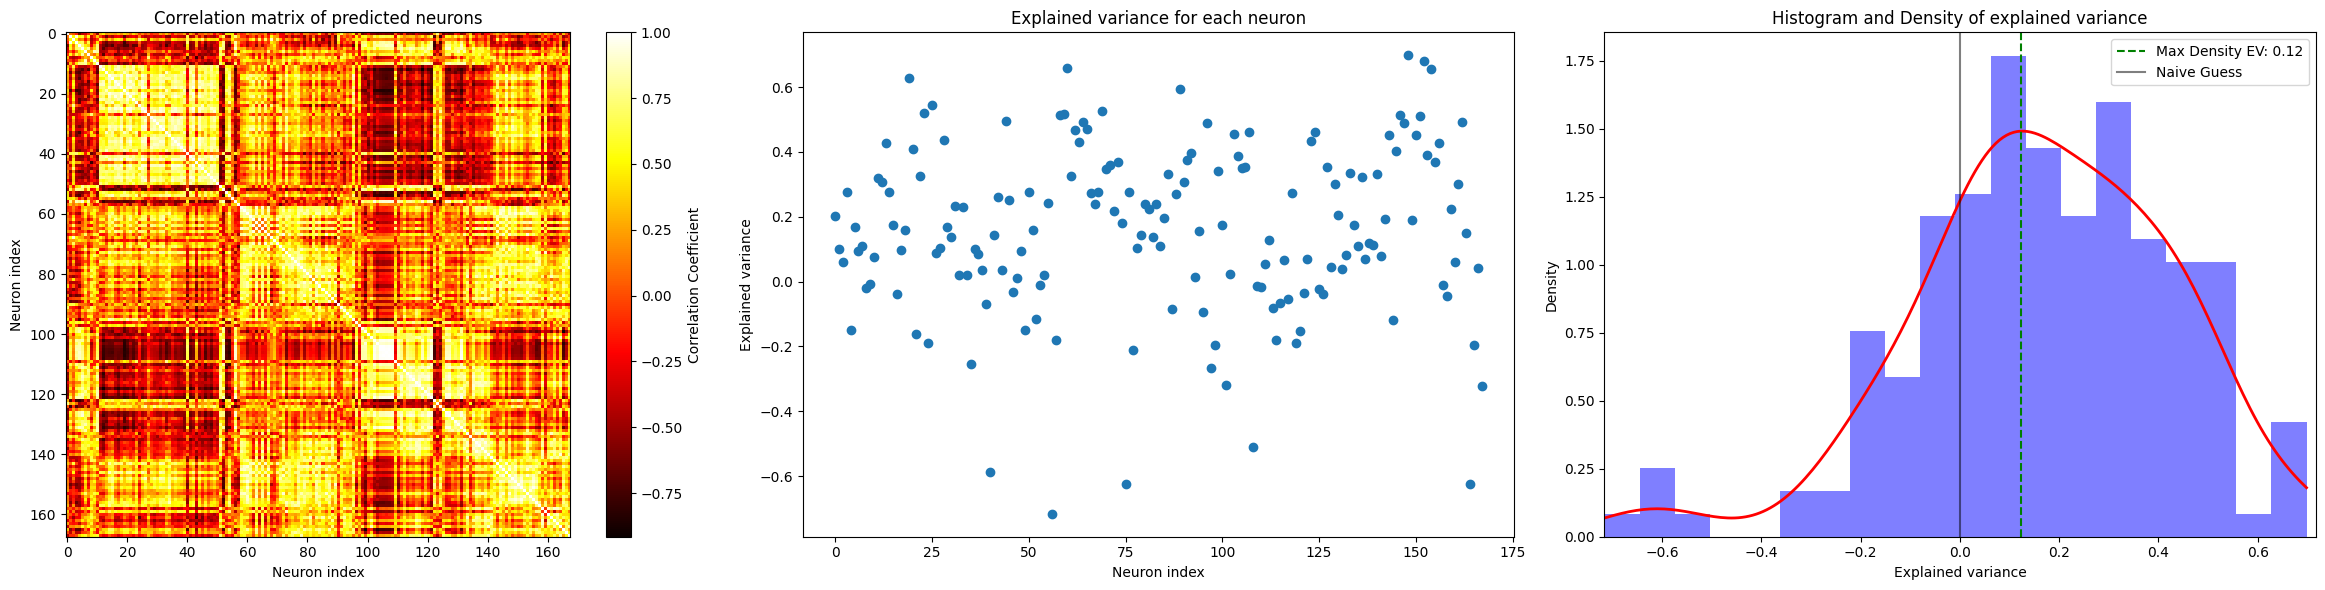

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


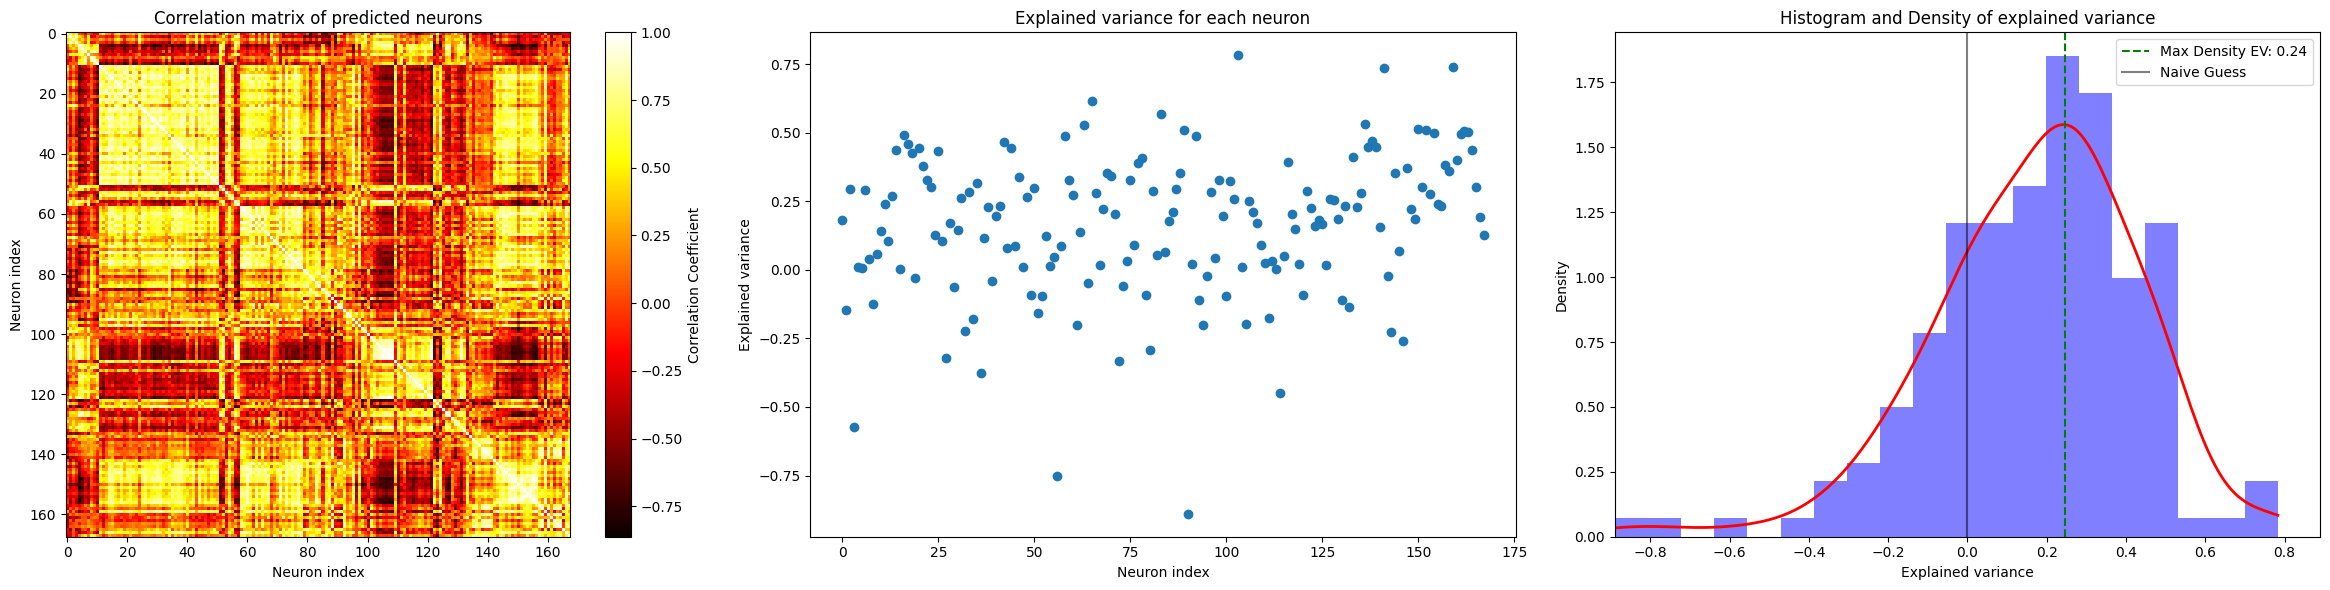

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


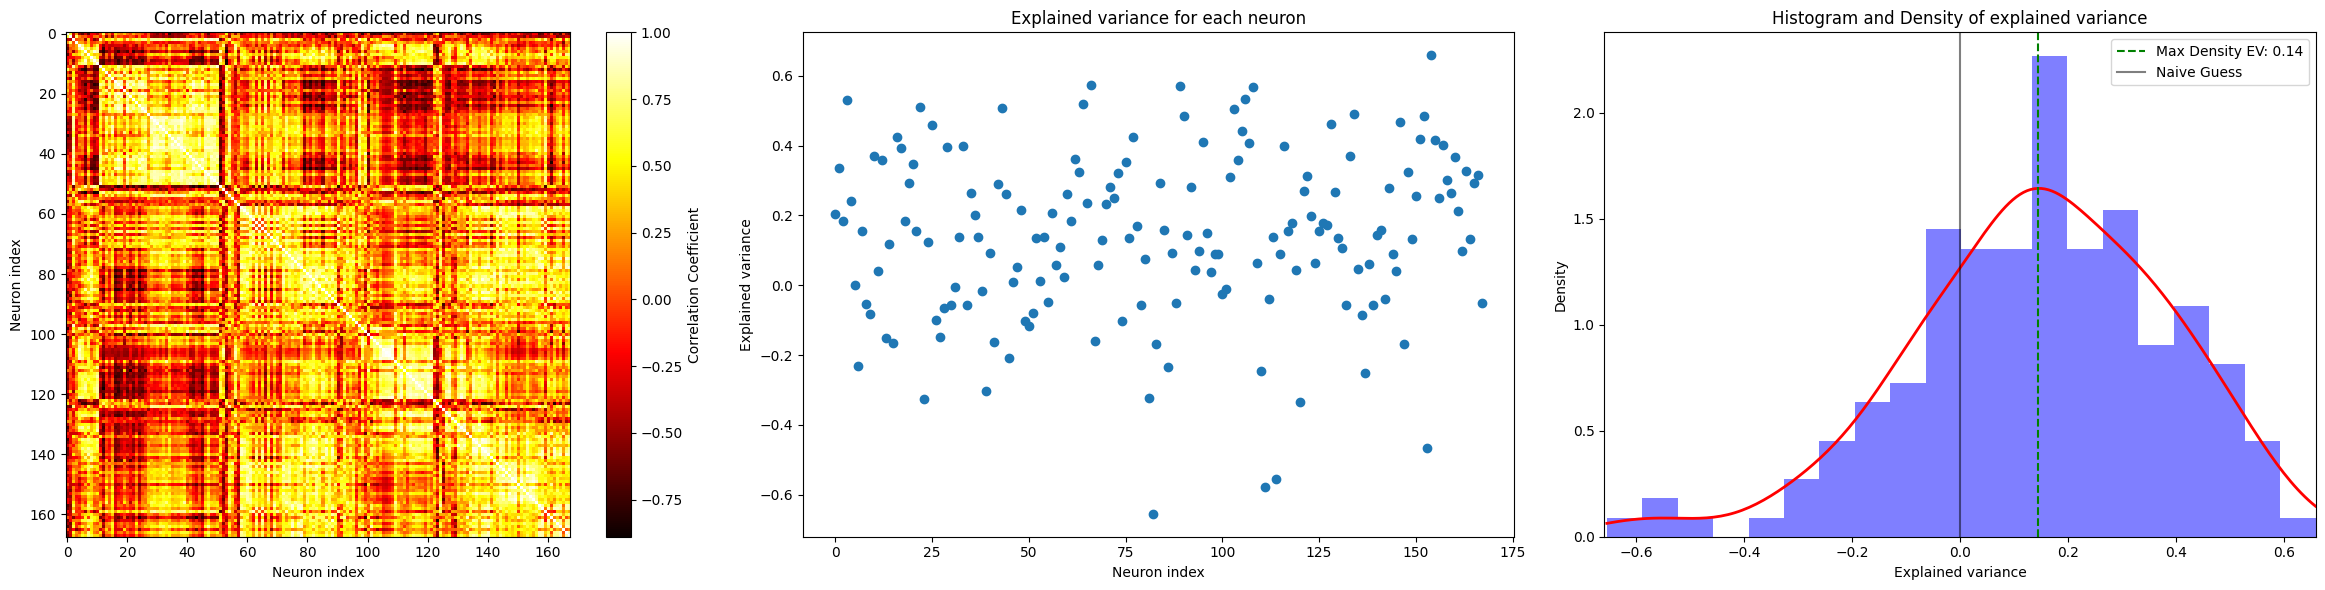

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


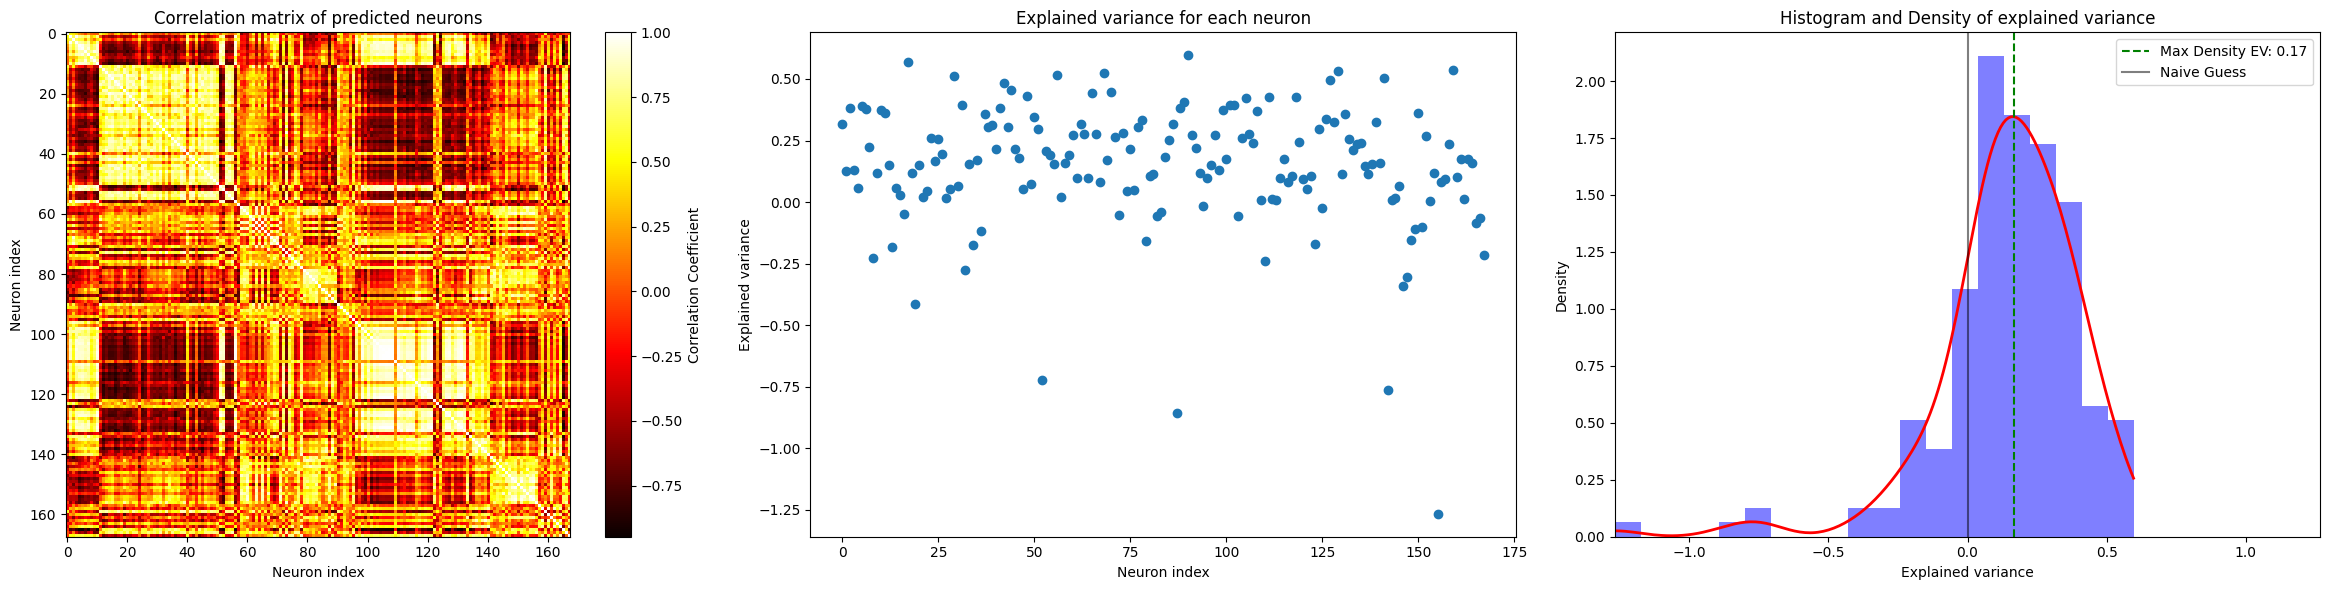

/tmp/2625394/ipykernel_257728/1653991718.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  outputs = np.array(outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_outputs = np.array(train_outputs.cpu())
/tmp/2625394/ipykernel_257728/1653991718.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spikes = np.array(spikes.cpu())


(16, 168) (16, 168) (16, 168)


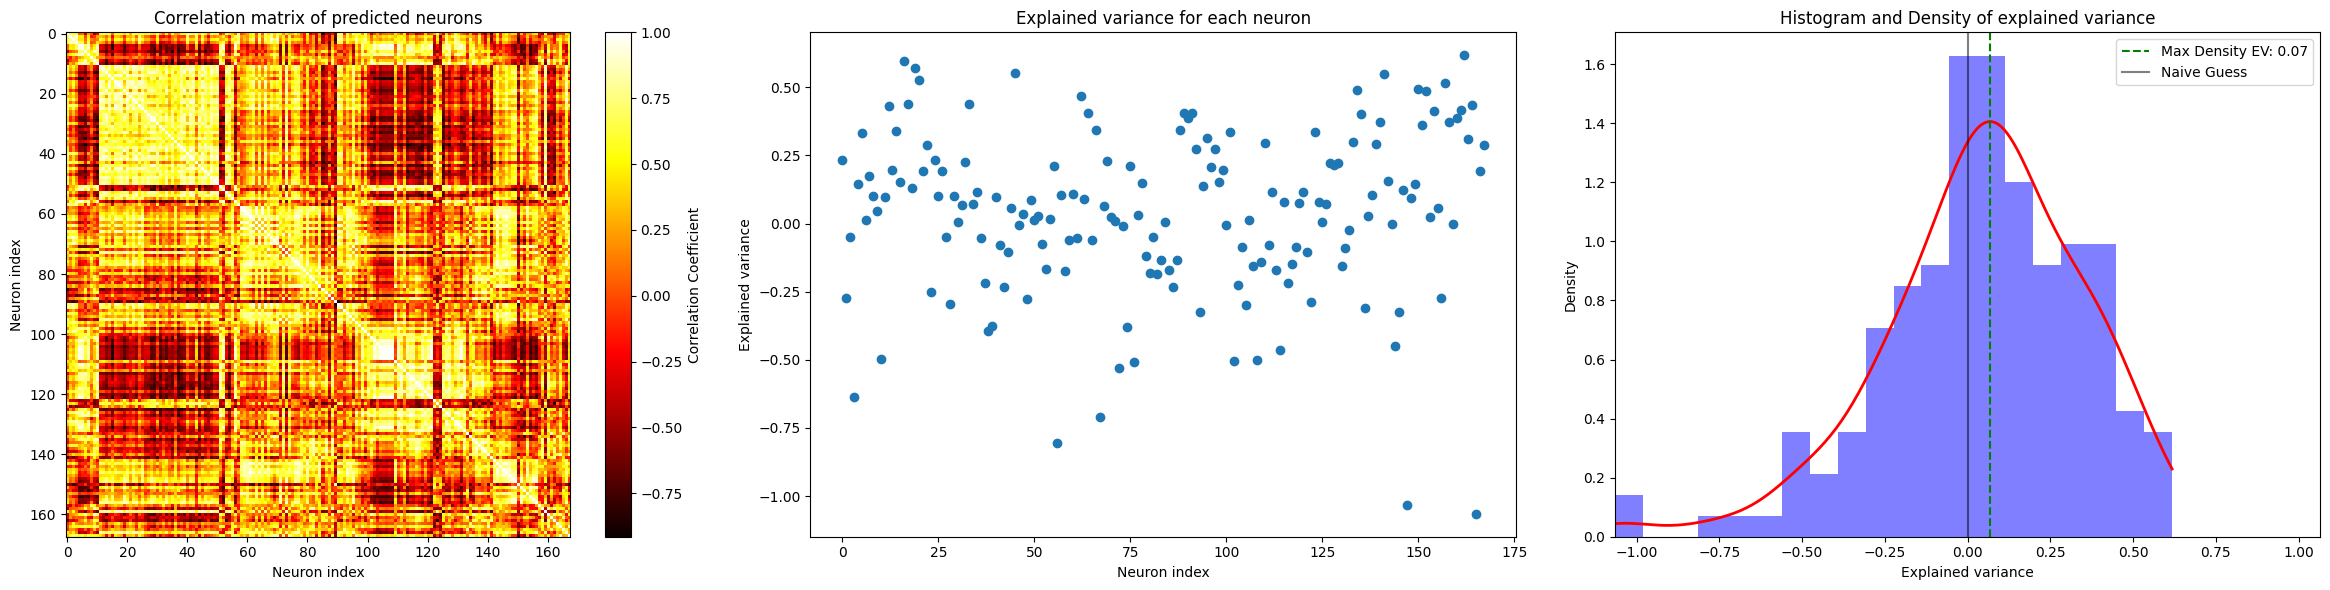

R2 Score: 0.17558467388153076
Explained Variance: 0.1859462559223175
Test MSE: 0.1119


(tensor([[ 0.1086,  0.0966,  0.2811,  ...,  0.1596,  0.0698, -0.0183],
         [-0.0640, -0.0746, -0.1367,  ...,  0.3562,  0.1543, -0.0231],
         [-0.0158, -0.2287,  0.1525,  ...,  0.1305, -0.1463,  0.0945],
         ...,
         [ 0.1481,  0.1201, -0.0219,  ...,  0.2220,  0.0898,  0.0123],
         [ 0.2219,  0.2329,  0.2918,  ...,  0.0993,  0.1149,  0.1142],
         [-0.1343, -0.1702, -0.0582,  ...,  0.2129,  0.0769,  0.1185]]),
 tensor([[-0.0879, -0.0164, -0.1340,  ...,  0.0284, -0.0085, -0.2074],
         [ 0.0270, -0.1447, -0.3623,  ...,  0.5289, -0.1783, -0.2455],
         [ 0.7358,  0.2244, -0.5893,  ...,  0.0200,  0.0358,  0.0454],
         ...,
         [-0.1834, -0.3004, -0.0761,  ..., -0.1735, -0.0329, -0.2970],
         [-0.0178, -0.0523,  0.8572,  ...,  0.1298,  0.3078,  0.1440],
         [-0.3014, -0.2094,  0.0112,  ...,  0.0796,  0.3452,  0.2394]]))

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_loader, test_loader = get_dataloaders(16, stimulus_train, spikes_train, stimulus_val, spikes_val)

model = CNN(height=img_size, width=img_size, output_n=n_neurons)
model.load_state_dict(torch.load('cnn_w7.pt'))
model.to(device)

print(type(train_loader))

evaluate_model(model, train_loader, test_loader, device)